In [24]:
import os
import sys
from importlib import reload
from pandas import DataFrame, read_csv
import seaborn as sns
import matplotlib.pyplot as plt


import sys 
sys.path = [
    '../libs/sublime',
    '../libs/imc-gae',
    '..',
    '../../.venv/'
]

In [25]:
sys.path

['../libs/sublime', '../libs/imc-gae', '..', '../../.venv/']

In [27]:
import pkgutil
# assert 'pipeline' in 
[pkg.name for pkg in pkgutil.iter_modules(sys.path) if pkg.ispkg]

[]

In [19]:
sys.path

['../libs/sublime', '../libs/imc-gae', '..', '../../.venv/']

Загрузим данные

In [19]:
data = read_csv('../data/refined/wide/blood_chemistry_17.csv', index_col=(0, 1))

In [3]:
import torch
device = 'gpu' if torch.cuda.is_available() else 'cpu'

Сгенерируем граф 6NN

In [3]:
from initializer import KNNInit
from sklearn.preprocessing import RobustScaler
from missing_sampler import UniformMissing
from pipeline import Preprocessor
from misc import columns_str2int

data_columns = data.columns.to_list()
target_columns = ['Potassium',
       'Sodium', 'Creatinine', 'Chloride', 'Urea Nitrogen', 'Bicarbonate',
       'Anion Gap', 'Glucose', 'Magnesium', 'Calcium, Total', 'Phosphate',]
droprate = 0.3



ModuleNotFoundError: No module named 'initializer'

## Исследуем возможные подзадачи для градиента
Проведём классификацию/регрессию на основе GB 

In [29]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, KFold
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, f1_score


cat_cols = ['allinref', 'gender_M', 'race_HISPANIC', 'race_BLACK', 'race_WHITE']
drop_cols = ['gender_F', 'race_UNKNOWN', 'charttime', 'time_cluster']
con_cols = [col for col in data.columns if col not in cat_cols and col not in drop_cols]

df = data.drop(drop_cols, axis=1)
df.loc[:, cat_cols] = df.loc[:, cat_cols].astype(int)



In [100]:
target_choice_result = DataFrame(
    columns=['target_col', 'type_', 'phase', 
    # 'scores'],
    'val_mean', 'val_std'],
     dtype='object', 
).set_index(['target_col', 'type_', 'phase',])


In [101]:
metrics = {
    'classification':'f1_micro', # f1_score,
    'regression': 'neg_mean_absolute_percentage_error'
}
models = {
    'classification': GradientBoostingClassifier(random_state=2104),
    'regression': GradientBoostingRegressor(random_state=2104)
}
from numpy import mean, std
for target_col in df.columns:
    y = df[target_col]
    X = df.drop(target_col, axis=1)

    type_ = 'classification' if target_col in cat_cols else 'regression'
    model = models[type_]
    metric = metrics[type_]

    scores = cross_validate(model, X, y, scoring=metric, 
        cv=KFold(10,), 
        verbose=0, fit_params=None, return_train_score=True,)
    
    target_choice_result.loc[(target_col, type_, 'train'), :] = mean(scores['train_score']),  std(scores['train_score'])
    target_choice_result.loc[(target_col, type_, 'test'), :] = mean(scores['test_score']),  std(scores['test_score'])




In [105]:
data[
    # ['race_HISPANIC', 'race_BLACK', 'race_WHITE', 'race_UNKNOWN']
    ['gender_F', 'gender_M']
].sum()/ data.shape[0]




gender_F    0.43789
gender_M    0.56211
dtype: float64

In [106]:
target_choice_result = target_choice_result.reset_index()

cls_res = target_choice_result[target_choice_result.type_ == 'classification'].drop('type_', axis=1)
regr_res = target_choice_result[target_choice_result.type_ == 'regression'].drop('type_', axis=1)

In [107]:
regr_res['val_mean'] *= -1

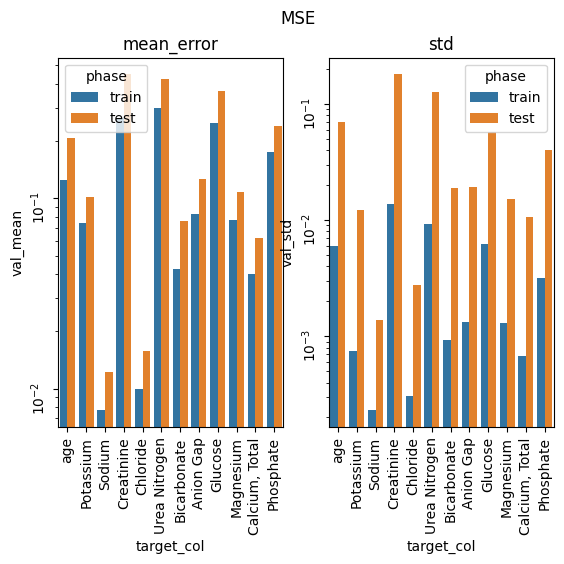

In [108]:
# cls_res.drop('index', inplace=True, axis=1)
# regr_res.drop('index', inplace=True, axis=1)

fig, axes = plt.subplots(1, 2)
sns.barplot(regr_res, hue='phase', y='val_mean', x='target_col', ax=axes[0])
sns.barplot(regr_res, hue='phase', y='val_std', x='target_col', ax=axes[1])
for ax in axes:
    ax.tick_params(labelrotation=90)
    ax.set_yscale('log')
axes[0].set_title('mean_error')
axes[1].set_title('std')
plt.suptitle('MSE');

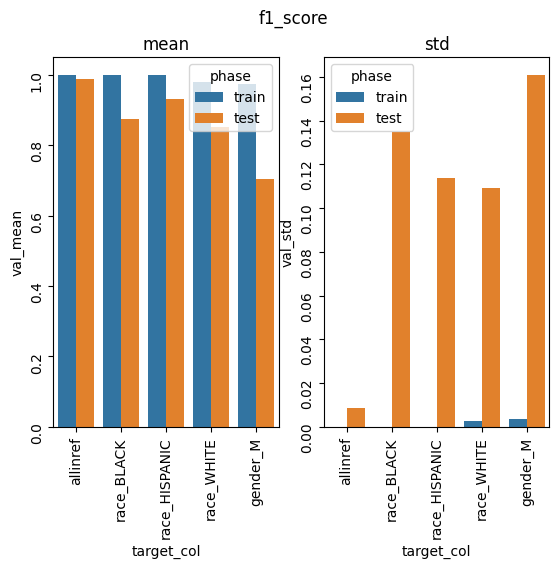

In [109]:
fig, axes = plt.subplots(1, 2)
sns.barplot(cls_res, hue='phase', y='val_mean', x='target_col', ax=axes[0])
sns.barplot(cls_res, hue='phase', y='val_std', x='target_col', ax=axes[1])
for ax in axes:
    ax.tick_params(labelrotation=90)
    # ax.set_yscale('log')
axes[0].set_title('mean')
axes[1].set_title('std')
fig.suptitle('f1_score');

## Запустим препроцессор
подготовка данных для экспериментов

In [5]:
pp = Preprocessor(
    UniformMissing(droprate, None, target_columns, data_cols=data_columns),
    KNNInit(n_neighbors=6),
    scale=True
)
attrs, G, mask = pp.run(data.values, 'graph', fill_value=0)

c:\Users\user\labevent\src\initializer.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(self.data, device=self.device),


Попробуем воспользоваться GCNMF

In [6]:
tmp = torch.tensor(data.to_numpy())
from imputation import GCNmfConv
GCNmfConv(21, 4, n_components=3, dropout=0)(attrs, G.edge_index, mask).size()

torch.Size([2085, 4])

In [7]:
y = attrs[:, -1]
X = attrs[:, columns_str2int(data_columns, target_columns)]

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_torch_csr_tensor
from torch_geometric.nn import SimpleConv

In [9]:
import importlib
import pipeline
import fp
import loss
import missing_sampler
import imputation
import initializer
import sublime as sb
import libs.sublime as sublime
to_reload = [pipeline, fp, loss, missing_sampler, imputation, initializer, sublime, sb]
for i in to_reload:
    importlib.reload(i)

from pipeline import Pipeline
from imputation import GCNmfImputer, GAEMF
from fp import FeaturePropagation
from loss import SeparableMSE
from missing_sampler import UniformMissing

In [10]:
sm = sb.SublimeModule()

In [11]:
result = sm(
    attrs, G.edge_index, 
)

c:\Users\user\labevent\src\libs/sublime\utils.py:200: UserWarning: torch.sparse.SparseTensor(indices, values, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, dtype=, device=). (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:608.)
  torch_sparse_mx = torch.sparse.FloatTensor(indices, values)
c:\Users\user\labevent\src\libs/sublime\utils.py:124: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(adj.indices(), new_values, adj.size())


NotImplementedError: Could not run 'aten::_values' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::_values' is only available for these backends: [Meta, SparseCPU, SparseCUDA, SparseMeta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Meta: registered at ..\aten\src\ATen\core\MetaFallbackKernel.cpp:23 [backend fallback]
SparseCPU: registered at aten\src\ATen\RegisterSparseCPU.cpp:1387 [kernel]
SparseCUDA: registered at aten\src\ATen\RegisterSparseCUDA.cpp:1573 [kernel]
SparseMeta: registered at aten\src\ATen\RegisterSparseMeta.cpp:249 [kernel]
BackendSelect: fallthrough registered at ..\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ..\aten\src\ATen\functorch\DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at aten\src\ATen\RegisterFunctionalization_3.cpp:24643 [kernel]
Named: registered at ..\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ..\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at ..\aten\src\ATen\native\NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at ..\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: registered at ..\torch\csrc\autograd\generated\ADInplaceOrViewType_1.cpp:5216 [kernel]
AutogradOther: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradCPU: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradCUDA: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradHIP: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradXLA: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradMPS: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradIPU: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradXPU: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradHPU: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradVE: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradLazy: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradMTIA: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradPrivateUse1: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradPrivateUse2: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradPrivateUse3: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradMeta: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
AutogradNestedTensor: registered at ..\torch\csrc\autograd\generated\VariableType_3.cpp:18740 [autograd kernel]
Tracer: registered at ..\torch\csrc\autograd\generated\TraceType_3.cpp:14672 [kernel]
AutocastCPU: fallthrough registered at ..\aten\src\ATen\autocast_mode.cpp:378 [backend fallback]
AutocastCUDA: fallthrough registered at ..\aten\src\ATen\autocast_mode.cpp:244 [backend fallback]
FuncTorchBatched: registered at ..\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:720 [backend fallback]
BatchedNestedTensor: registered at ..\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:746 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ..\aten\src\ATen\functorch\VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at ..\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at ..\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ..\aten\src\ATen\functorch\TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ..\aten\src\ATen\functorch\DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:158 [backend fallback]


In [14]:
from torch_geometric.utils import to_torch_coo_tensor
type(to_torch_coo_tensor(G.edge_index))

torch.Tensor

In [ ]:
param_sampler = {'UniformMissing': {
    'droprate': [
        0.1, 
        # 0.3, 0.5, 0.75,
        #   .9
          ],
    'data_cols': [data_columns],
    'target_cols': [target_columns],
    }
}
param_init = {
    'KNNInit': {
        'n_neighbors': [2, 4, 5, 8]
    },
    'RandomInit': {
        'random_graph': ['erdos_renyi'],
        'edge_prob': [0.01, 0.05, 0.1, 0.25, 0.5]
    },
    'EpsilonRadiusInit': {
        'radius': [0.1, .5]
    },
    'FeatureCliqueInit': {
        'division_factor': [5, 10],
        'column_indices': [[1]]
    }

}
param_imp = {
    'FeaturePropagation': {
        'n_iterations': [0, 1, 2, 4, 8]
    },
    'GCNmfImputer': {
        'train_epochs': [1, 2,],
        'model': [
            GAEMF(
                (21, 32, 8),
                (8, 21), 
                n_comp=3
            ),
            # GAEMF(
            #     (21, 32, 8),
            #     (8, 21), 
            #     dropout=.1,
            #     n_comp=3
            # ),
            # GAEMF(
            #     (21, 32, 8),
            #     (8, 21), 
            #     dropout=.1,
            #     n_comp=3
            # ),
        ]
    }
}

from itertools import product
def product_param(d):
    keys, values = zip(*d.items())
    return [dict(zip(keys, v)) for v in product(*values)]


def experimental_settings(sampler: str, initer: str, imputer: str):
    for samp, init, imp in product(
        product_param(param_sampler[sampler]),
        product_param(param_init[initer]),
        product_param(param_imp[imputer]),
    ):
        yield ({'sampler': samp,
               'initer': init,
               'imputer': imp}, 
               {'sampler': sampler,
               'initer': initer,
               'imputer': imputer}, 
               ), Pipeline(
            Preprocessor(
                getattr(missing_sampler, sampler)(**samp),
                getattr(initializer, initer)(**init),
                scale=True
            ),
            getattr(imputation, imputer)(**imp),
            SeparableMSE(True),
        )

In [6]:
import sublime

In [8]:
results = DataFrame(columns=['type', 'sampler', 'initer',  'imputer', *target_columns])

In [9]:
path = '../data/callbacks'
if not os.path.exists(path):
    os.mkdir('../data/callbacks')

In [21]:
colmask = columns_str2int(data, target_columns)
n = 5
from datetime import datetime
for sampler, initer, imputer in product(
    ['UniformMissing'],
    ['KNNInit', 'EpsilonRadiusInit', 'RandomInit', 'FeatureCliqueInit'],
    [
        'FeaturePropagation', 
     'GCNmfImputer']
):  
    for param, pipeline in experimental_settings(sampler, initer, imputer):
        res = torch.stack(pipeline.eval(data, n))
        header = [
            (param[0][stage], param[1][stage]) for stage in ['sampler', 'initer', 'imputer']
        ]
        results.loc[results.shape[0] + 1] = ['mean'] + header + res.mean(0)[colmask].tolist()
        results.loc[results.shape[0] + 1] = ['std'] + header + res.std(0)[colmask].tolist()
    results.to_csv(os.path.join(path, f'results{str(datetime.today().date())}.csv'))
        
    

Trial:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\user\labevent\src\imputation.py:296: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:620.)
  adj = torch.sparse.FloatTensor(edge_index, values=edge_weight, size=(n_nodes, n_nodes)).to(edge_index.device)


KeyError: 'discretize_func'